In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import pandas as pd
from collections import OrderedDict
from context import lwr_inverse

from lwr_inverse.tools.vis import mcmc_vis_tools
from lwr_inverse.tools.vis.vis_util import plot_LWR_xt
from lwr_inverse.lwr.lwr_solver import LWR_Solver
from lwr_inverse.tools.util import FD_neg_power

from lwr_inverse.samplers.mhsampler import MHSampler
from lwr_inverse.moves.gaussian import GaussianMove

# Del Cast FD: direct fit to M25 data



In [2]:
config_dict = {'my_analysis_dir': '2019',
                'run_num': 1,
                'data_array_dict':
                        {'flow': 'data_array_70108_flow_49t.csv',
                        'density': 'data_array_70108_density_49t.csv'},
                      'ratio_times_BCs': 40,
                      }
LWR = LWR_Solver(config_dict=config_dict)


In [3]:
data_df = LWR.df_FD_data
flow_obs = data_df.flow.values


def log_lik(z, rho_j, u, w):
    model_fun = lambda x: FD_neg_power(rho=x, z=z, rho_j=rho_j, u=u, w=1/w)
    pred_flow = model_fun(data_df.density.values)
    return np.sum(- pred_flow + flow_obs*np.log(pred_flow))


def log_post(z, rho_j, u, w):
    return log_lik(z, rho_j, u, w)

In [4]:
ICs = { 'z': 202, 'rho_j': 548.8, 'u': 3.991, 'w': 0.4878,}


cov = np.array([[ 182.292318  , -288.07905   ,   -2.34389543,    1.21897887],
       [-288.07905   ,  561.808314  ,    5.26749447,   -1.7470824 ],
       [  -2.34389543,    5.26749447,    0.08204741,   -0.00839764],
       [   1.21897887,   -1.7470824 ,   -0.00839764,    0.00931977]])

mcmc = MHSampler(log_post=log_post, ICs=ICs, verbose=2)
mcmc.move = GaussianMove(param_info=ICs, cov=cov)

In [5]:
mcmc.run(10000, 5000)

Iteration 5000/10000
Iteration 10000/10000

Acceptance rate: 24.93

MSEJD: 106.955


In [6]:
plt.rcParams.update({'font.size': 12})

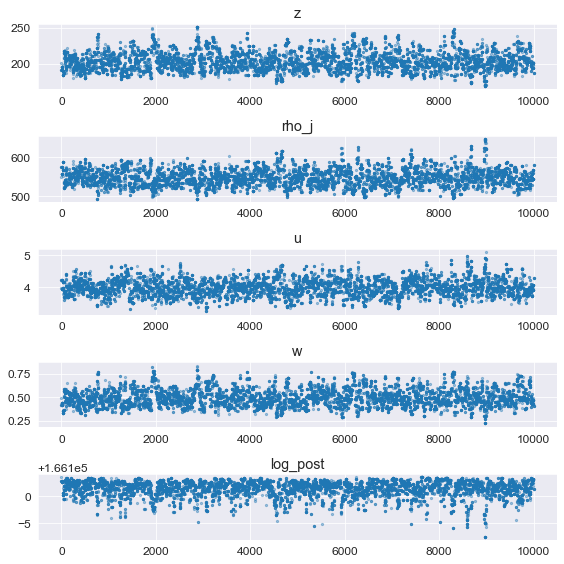

In [7]:

burnin = 0

mcmc.trace_plots(burnin=burnin)

# plt.savefig("DelCastDS1-directfit-traceplots.png")

In [8]:
plt.rcParams.update({'font.size': 20})

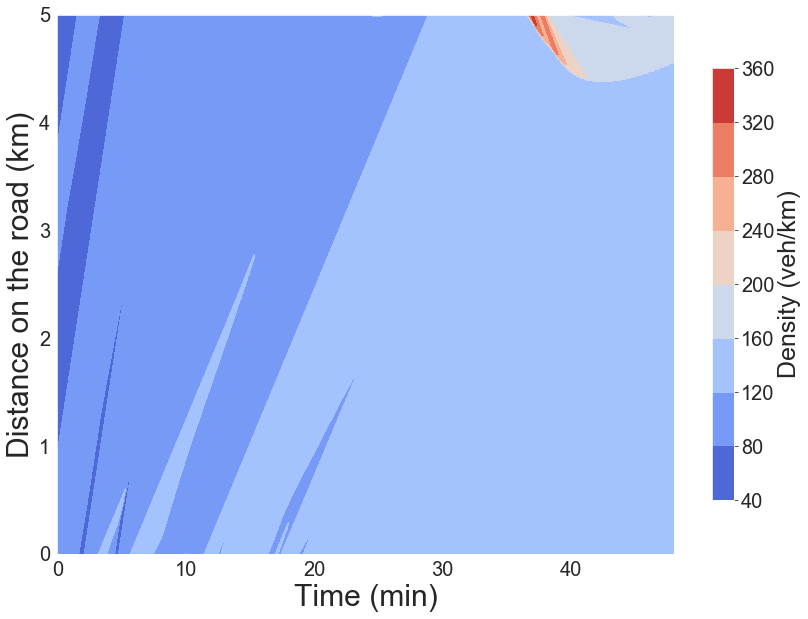

In [9]:
df_mean = mcmc.all_samples[['z', 'rho_j', 'u', 'w']].mean()

FD = df_mean.to_dict()
FD['w'] = 1/FD.pop("w")
FD['solver'] = 'lwr_del_Cast'
FD['BC_outlet'] = LWR.high_res_BCs('BC_outlet')
FD['BC_inlet'] = LWR.high_res_BCs('BC_inlet')

title_save = None
# title_save = "DelCastDS1_directfit-XT_density.png"

plot_LWR_xt(FD=FD, data_variable='density', config_dict=config_dict, 
            out_times=np.linspace(0,40*LWR.final_time, 1200), title_save=title_save)

/Users/jeremiecoullon/Documents/research/phd/lwr_inverse/lwr_inverse/tools/util.py:262: RuntimeWarning: divide by zero encountered in power
  return z * ( (u*rho/rho_j)**(-w) + (1-rho/rho_j)**(-w) )**(-1/w)
/Users/jeremiecoullon/Documents/research/phd/lwr_inverse/lwr_inverse/tools/util.py:262: RuntimeWarning: invalid value encountered in power
  return z * ( (u*rho/rho_j)**(-w) + (1-rho/rho_j)**(-w) )**(-1/w)


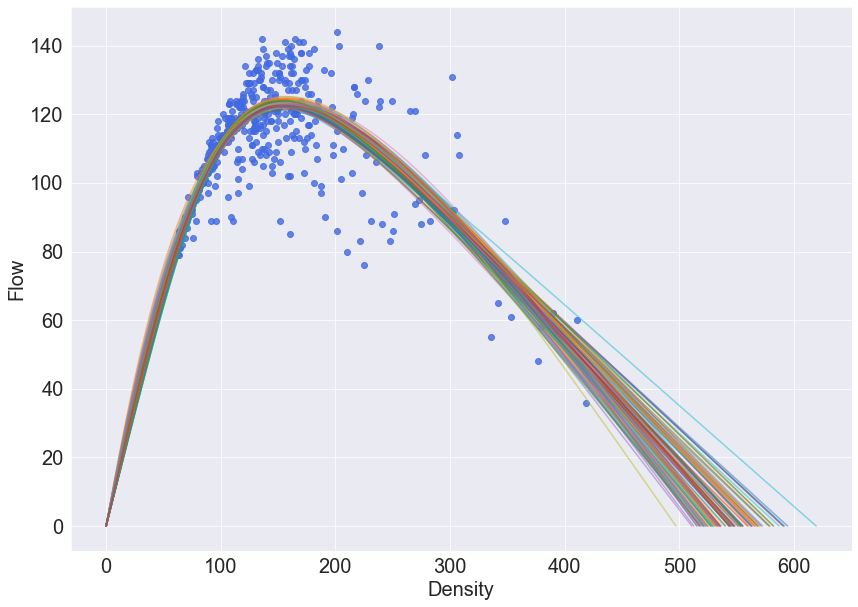

In [10]:
x_range = np.arange(0, 650, 0.1)

plt.figure(figsize=(14,10))
plt.scatter(data_df.density, data_df.flow, alpha=0.8, c='royalblue')

step = 100
burnin = 500
for elem in mcmc.all_samples[['z','rho_j', 'u','w']].values[burnin::step]:
    FD_data = FD_neg_power(rho=x_range, z=elem[0], rho_j=elem[1], u=elem[2], w=1/elem[3])
    plt.plot(x_range, FD_data, alpha=0.5)
    
plt.xlabel("Density", size=20)
plt.ylabel("Flow", size=20)
    
# plt.savefig("delCastDS1_directfit-FD_cloud.png")
plt.show()